In [1]:
# Xiaopu Peng

In [1]:
# check whats in the root folder
from subprocess import check_output
print(check_output(['ls', './']).decode('utf8'))

CompareExps
ExpBasic.ipynb
ExpNoRedux.ipynb
Methods.py
Methods.pyc
NewDevelop
README.md
Redux.py
__pycache__
backup-grid-cost-forecasting
data
detailedResults.txt
plots
sandbox



### Imports

In [2]:
# import sys
# sys.path.insert(0, '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/')
import Methods as mt
import numpy as np
import pandas as pd
# %matplotlib inline
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import Redux as rd
plt.style.use('ggplot')
# plt.style.use('default')

### Initialize

In [3]:
# ############CONSTANT############
# ratio of stats count when start the arithmetic average estimate
scaleRatio = 0.01
# ability of ups devise, could be more sophisticated in future (kWh)
upsCapability = 500
# the workload processing capability of data center (by kWh energy need)
workloadCapability = 2500
# ups and renewable energy price ($)
upsPrice = 0.02
solarPrice = 0.09
windPrice = 0.15

# ##############INITIALIZE###################
# initialized ups original storage by ratio
initUpsStorage = upsCapability * 0.5
# save the amount of deferred workload to a cache
initWorkloadPool = 0
# the initialized threshold of grid price ($)
initGridpriceThreshold = 1.0
# initialized high and low ratio of current workload for workload shaving
initCurWorkloadRatio = 0.2
# initialized stable renewable supply level
initStableRenSupply = 500
# initialize statistic recorders  and
gridpriceStat = []
workloadStat = []
renSupplyStat = []
fluRenSupplyStat = []  # renewable supply fluctuation
stableRenSupplyStat = []  # stable renewable supply

# initialize all statistical records
reduxStat = []
reduxAccu = []
noReduxStat = []
noReduxAccu = []
noRenStat = []
noRenAccu = []
costGapStat = []
specialCase = []


reupsStat = []
reupsAccu = []
greenswitchStat = []
greenswitchAccu = []
#######################################

In [4]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
check_output             function    <function check_output at 0x10a1f7b00>
costGapStat              list        n=0
fluRenSupplyStat         list        n=0
greenswitchAccu          list        n=0
greenswitchStat          list        n=0
gridpriceStat            list        n=0
initCurWorkloadRatio     float       0.2
initGridpriceThreshold   float       1.0
initStableRenSupply      int         500
initUpsStorage           float       250.0
initWorkloadPool         int         0
mt                       module      <module 'Methods' from '/<...>kspace/Redux/Methods.py'>
noReduxAccu              list        n=0
noReduxStat              list        n=0
noRenAccu                list        n=0
noRenStat                list        n=0
np                       module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pd                       module      <module 'pandas' from '/U<...>age

### Dataset

In [5]:
dataDir = '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/data/'
# dataDir = 'C:/Users/xiaop/Dropbox/workspace/Redux/data/'
workloadData, gridpriceData, solarSupplyData, windSupplyData, renSupplyData = mt.loadData(dataDir)

### Preprocess (solar&wind model)

### topLevel

In [6]:
gridpriceThreshold = initGridpriceThreshold
workloadPool = 0
upsStorage = upsCapability * 0.5
curWorkloadRatio = initCurWorkloadRatio
stableRenSupply = initStableRenSupply

curTime = 0
finTime = 2568  # number of timeslots
WINDOW = finTime * scaleRatio

while curTime < finTime:
    # print('current time:', curTime)

    # derive renewable price by weighted average from wind and solar price
    renPrice = (windSupplyData[curTime] * windPrice + solarSupplyData[curTime] * solarPrice) / (windSupplyData[curTime] + solarSupplyData[curTime])

    # get the current grid price, append to grid price statistic and decide whether it is high or low
    gridPrice = gridpriceData[curTime]
    gridpriceStat.append(gridPrice)

    # call method to estimate grid price state
    gridpriceThreshold, gridpriceState = mt.estimateGridPriceState(gridpriceStat, gridpriceThreshold, finTime, gridPrice, scaleRatio)

    # get the current workload and append to workload statistic, use real trace data for the next step
    curWorkload = workloadData[curTime]

    # get the current workload and append to workload statistic
    renSupply = renSupplyData[curTime]
    renSupplyStat.append(renSupply)

    # ########### REDUX methods begin ################
    # first, do workload shaving to avoid over-capability load
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadCapability, workloadPool)
    workloadStat.append(curWorkload)

    # then smoothing the current workload by exponential windowed avarage
    curWorkload, workloadPool = mt.workloadSmoothing(curWorkload, workloadPool, workloadStat, WINDOW)

    # calculate total cost without Redux, without renewable energy
    noRenCost = gridPrice * curWorkload
    noRenStat.append(noRenCost)

    # calculate greenswitchCost (noRedux, but with renewable energy)
    greenswitchCost = mt.calculateGreenswitchCost(renSupply, curWorkload, workloadPool, gridPrice, renPrice)
    greenswitchStat.append(greenswitchCost)
    
    # ########## update states or thresholds ############
    # update the high and low ratio of workload according to smoothed workload, will approach to 0.8 and 0.2 as when more workload recorded
    curWorkloadHighRatio, curWorkloadLowRatio = mt.updateWorkloadRatio(workloadStat, finTime, curWorkloadRatio, scaleRatio)

    workloadState = mt.updateWorkloadState(curWorkload, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability)

    # decide utilization level of ups for current time spot
    upsAbility = mt.updateUpsUtilityLevel(workloadState, upsCapability)

    ############################################
    # define renewable state
    # we need to figure out how to define fluctuate and tell why we still use grid as
    # much as possible when grid price is low(by always set a low price), otherwise we lost our motivation
    renState = mt.defineRenState(renSupply, renSupplyStat, renSupplyData, WINDOW)
    ##############################################

    # smoothing supply and demand if necessary
    if renState == 'fluctuate':
        # record the fluctuating renewable supply
        fluRenSupplyStat.append(renSupply)
        # update the stable renewable supply level by historical fluctuate renewable supply stat
        stableRenSupply = mt.getStableRenSupply(fluRenSupplyStat, WINDOW)
        # conduct renewable energy supply
        renSupply, upsStorage, stableGridSupply, upsSupplyFlu = mt.renSupplySmooth(gridpriceState, gridPrice, renSupply, renPrice, stableRenSupply, upsAbility, upsStorage)
    else:
        upsSupplyFlu = 0
        stableGridSupply = 0
        
    # dynamically decide overpeak workload level
    workloadOVR = mt.updateOverpeak(gridpriceState, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability, workloadPool, renState, renSupply, stableRenSupply, gridPrice, renPrice)

    # status['workloadState'] == 'overPeak'
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadOVR, workloadPool)

    # decide whether discharge or recharge UPS
    upsSupply, upsStorage = mt.updateUpsSupply(gridpriceState, curWorkload, workloadOVR, renState, upsStorage, upsCapability, upsSupplyFlu)

    # waste renSupply if it is higher than curWorkload
    if renSupply + upsSupply > curWorkload:
        renSupply = curWorkload - upsSupply

    # find gridSupply by supply constrain
    gridSupply = curWorkload - renSupply - upsSupply + stableGridSupply

    # calculate redux cost
    reduxCost = gridPrice * gridSupply + renPrice * renSupply + upsPrice * abs(upsSupply)

    reduxStat.append(reduxCost)

    # # we need to notice there are cases when cost with redux is higer than cost without redux, due to recharge the UPS batteries.
    # costGapStat.append(noReduxCost - reduxCost)
    # if costGapStat[curTime] < 0:
    #     specialCase.append(curTime)

    reduxAccu.append(sum(reduxStat))
    greenswitchAccu.append(sum(greenswitchStat))
    noRenAccu.append(sum(noRenStat))

    curTime += 1

print("Finished")

Finished


### noREDUX plot

<IPython.core.display.Javascript object>


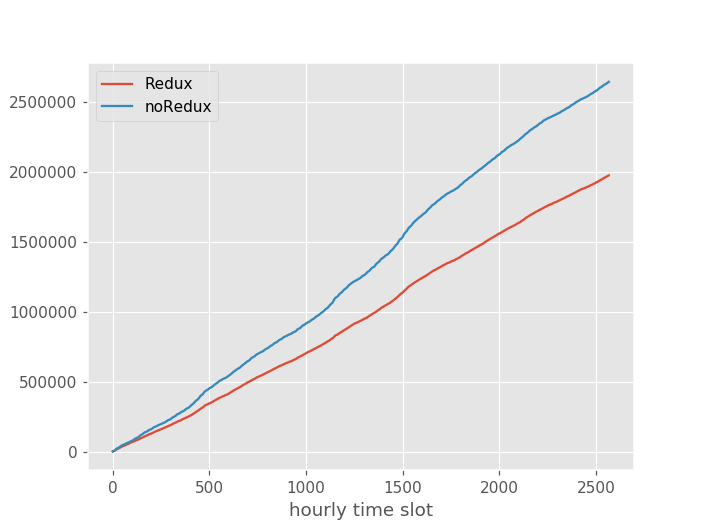

In [7]:
plt.plot(reduxAccu, label='Redux')
# plt.plot(greenswitchAccu, label='GreenSwitch')
plt.plot(noRenAccu, label='noRedux')
plt.xlabel('hourly time slot')
plt.ylabel('million dollars')
# plt.title('Accumulative total cost of Redux and without Redux')
plt.legend(loc='best')
plt.show()

In [8]:
plt.savefig('plots/noREDUX.png')
plt.close()

### smoothed current workload plot

In [15]:
WINDOW *= 0.5
smoothedCurworkload = pd.Series(workloadData).ewm(span=WINDOW).mean()

<IPython.core.display.Javascript object>


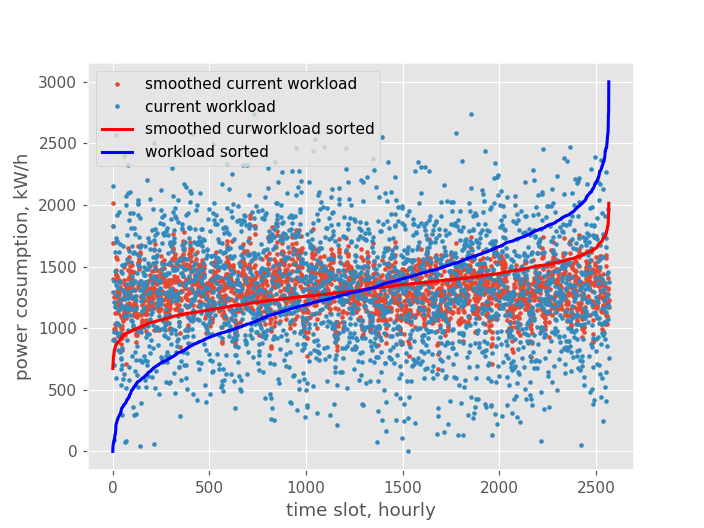

In [16]:
plt.plot(smoothedCurworkload, 'o', markersize = 2, label="smoothed current workload")
plt.plot(workloadData, 'o', markersize = 2, label = "current workload")
plt.show()

In [17]:
plt.plot(sorted(smoothedCurworkload), color='r', label="smoothed curworkload sorted", linewidth=2)
plt.plot(sorted(workloadData), color='b', label="workload sorted", linewidth=2)
plt.show()

In [18]:
plt.legend(loc='best')
plt.xlabel('time slot, hourly')
plt.ylabel('power cosumption, kW/h')
# plt.title('current workload before and after smoothing')

Text(32.19444598754247, 0.5, 'power cosumption, kW/h')

In [19]:
plt.savefig('plots/smoothCurWorkload.png')
plt.close()

### Show special case

<IPython.core.display.Javascript object>


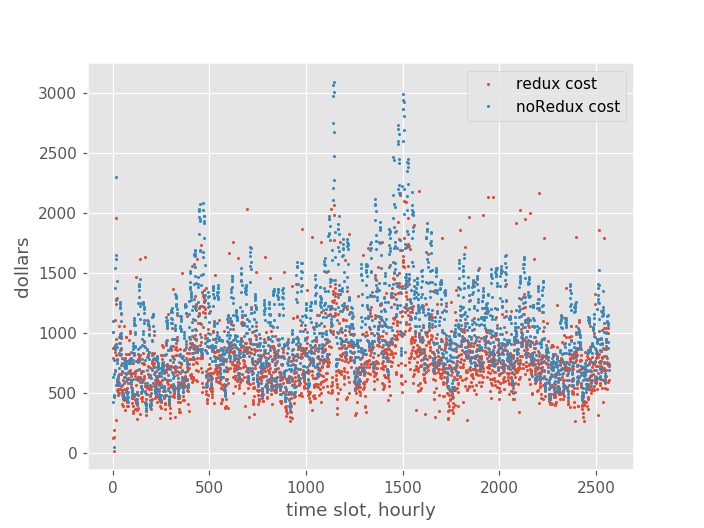

In [20]:
plt.plot(reduxStat, 'o', label='redux cost', markersize=1)
plt.plot(noRenStat, 'o', label='noRedux cost', markersize=1)
plt.xlabel('time slot, hourly')
plt.ylabel('dollars')
plt.legend(loc='best')

In [21]:
plt.savefig('plots/costCompare.png')
plt.close()

In [15]:
# How to plot 3 graphs together
# for i, col, in enumerate(features.columns):
#     plt.subplot(1, 3, i+1)
#     x = data[col]
#     y = prices
#     plt.plot(x,y,'o')
#     plt.plot(np.unique(x), npplot1d(np.plotfit(x,y,1))(np.unique(x)))
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylable('prices')